# Suspect Actives

Inspect cases where the number of inactives for a compound is greater than the number of actives.

In [1]:
from collections import defaultdict

from math import log10, floor, ceil

from itertools import chain

import seaborn as sns

### Configuration

In [2]:
marker_class_col, color_class_col = 'standard_relation', 'description'

In [3]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

In [4]:
sns.set()

### Get suspect actives

See SQL files '[tt_activity_counts](SQL/tt_activity_counts.sql)' for further details.

In [5]:
print(open('SQL/tt_activity_counts.sql').read())

----------------------------------------------------------------------------------------------------
-- 
-- Count active and inactive records for compounds.
-- 
-- Note that 'compounds' are here defined in terms of USMILES.
-- 
-- Note also that 'targets' are defined in terms of symbol/species pairs.
--
-- Note use of source table 'tt_curve_data_v2'; this is to get a full picture of the inactives.
-- 
----------------------------------------------------------------------------------------------------

-- drop table tt_activity_counts;

--

-- 

create table tt_activity_counts as
select
    a.*
  , case when ((a.n_active > 0) and (a.n_inactive > a.n_active)) then 1 else 0 end as suspect
from (
  select
      a.symbol
    , a.species
    , b.usmiles
    , count(case when nvl(a.active, 0) = 1 then 1 end) n_active
    , count(case when nvl(a.active, 0) = 0 then 1 end) n_inactive
    , count(*) n_total
  from
    tt_curve_data_v2 a
    join tt_structure_lookup b on a.parent_cmpd_chemblid = 

In [6]:
# NB Complicated query is to avoid division-by-zero errors...

suspect = pd.read_sql("""
select 
    a.symbol
  , a.species
  , count(case when a.suspect = 1 then 1 end) as n_suspect
  , count(case when a.n_active > 0 then 1 end) as n_active
  , round(count(case when a.suspect = 1 then 1 end)/count(case when a.n_active > 0 then 1 end) * 100.0, 1) as pct_suspect
from
  tt_activity_counts a
  join (
    select 
        symbol
      , species
      , count(case when n_active > 0 then 1 end) as n_active
    from
      tt_activity_counts a
    group by
        symbol
      , species
  ) b on a.symbol = b.symbol and a.species = b.species
where
  b.n_active > 0
group by
    a.symbol
  , a.species
order by
  pct_suspect desc
  , a.symbol
  , a.species
""", engine)

suspect.shape

(270, 5)

In [7]:
suspect.query("n_active > 50 and pct_suspect >= 3")

,symbol,species,n_suspect,n_active,pct_suspect
0,GRIN1,Rat,108,706,15.3
3,KCNJ11,Human,8,84,9.5
5,VDR,Human,12,176,6.8
7,GRIN1,Human,17,273,6.2
10,AHR,Human,6,172,3.5
11,CHRNA1,Human,2,58,3.4
12,DRD1,Human,23,687,3.3


### Targets

Inspect data for targets with high fraction of 'suspect' data points.

In [8]:
# symbol, species = 'GRIN1', 'Rat'

symbol, species = 'KCNJ11', 'Human'

# symbol, species = 'VDR', 'Human'

In [9]:
# Minimum number of activities to keep assay in plot..

min_n = 2

In [10]:
# Get raw data...

data = pd.read_sql("""
select
      a.*
    , b.usmiles
from
     tt_curve_data_v2 a
join tt_structure_lookup b on a.parent_cmpd_chemblid = b.cmpd
join tt_activity_counts c on a.symbol = c.symbol and a.species = c.species and b.usmiles = c.usmiles
where
    a.symbol  = :symbol
and a.species = :species
and c.suspect = 1
and a.exclude = 0
and a.nat >= 10
and a.nat <= 50
order by
    b.usmiles
  , a.parent_cmpd_chemblid
  , a.description
  , a.standard_relation
  , a.active
""", engine, params={'symbol': symbol, 'species': species})

data.shape

(34, 36)

### Table of assays

In [11]:
# Table of assays...

table_of_assays = data.groupby(['description', 'assay_chemblid']).apply(len).to_frame(name='n').reset_index().sort(['n', 'description'], ascending=[0, 1])

table_of_assays.shape

(13, 3)

In [12]:
# Discard smaller assays...

table_of_assays.query("n < @min_n").shape

(9, 3)

In [13]:
table_of_assays = table_of_assays.query("n >= @min_n")

table_of_assays.shape

(4, 3)

In [14]:
# Take only data from larger assays...

assay_chemblids = table_of_assays['assay_chemblid'].tolist()

data_0 = data

data = data.query("assay_chemblid in @assay_chemblids").reset_index(drop=True)

data.shape

(25, 36)

In [15]:
# Add index number of USMILES (i.e. as they will appear on X-axis of plot)...

data['usmiles_n'] = pd.Categorical.from_array(data['usmiles']).categories.get_indexer(data['usmiles'])

### Table of compounds

In [16]:
# Table of compounds...

table_of_compounds = data[['usmiles', 'parent_cmpd_chemblid']].drop_duplicates().groupby('usmiles').apply(lambda x: sorted(x['parent_cmpd_chemblid'])).to_frame('cmpds').reset_index()

table_of_compounds.index.name = 'usmiles_n'

table_of_compounds.shape

(8, 2)

### Plot chart

In [17]:
data[marker_class_col] = data[marker_class_col].fillna(' ')

In [18]:
# Colours...

def get_color_map(n_classes):

    n1 = int(round(n_classes/2))*2 # Round up to next even number for convenience
        
    color_map = plt.get_cmap('jet')(np.linspace(0.0, 1.0, n1))

    return color_map[list(chain.from_iterable(zip(range(0, int(n1/2)), range(int(n1/2), n1))))[:n_classes]]

color_classes = sorted(data[color_class_col].unique())

color_map = get_color_map(len(color_classes))

In [19]:
# Marker shape...

marker_classes = sorted(data[marker_class_col].unique())

marker_list = ['o', 's', '^']

In [20]:
# List of USMILES for X-axis...

usmiles = table_of_compounds['usmiles'].tolist()

len(usmiles)

8

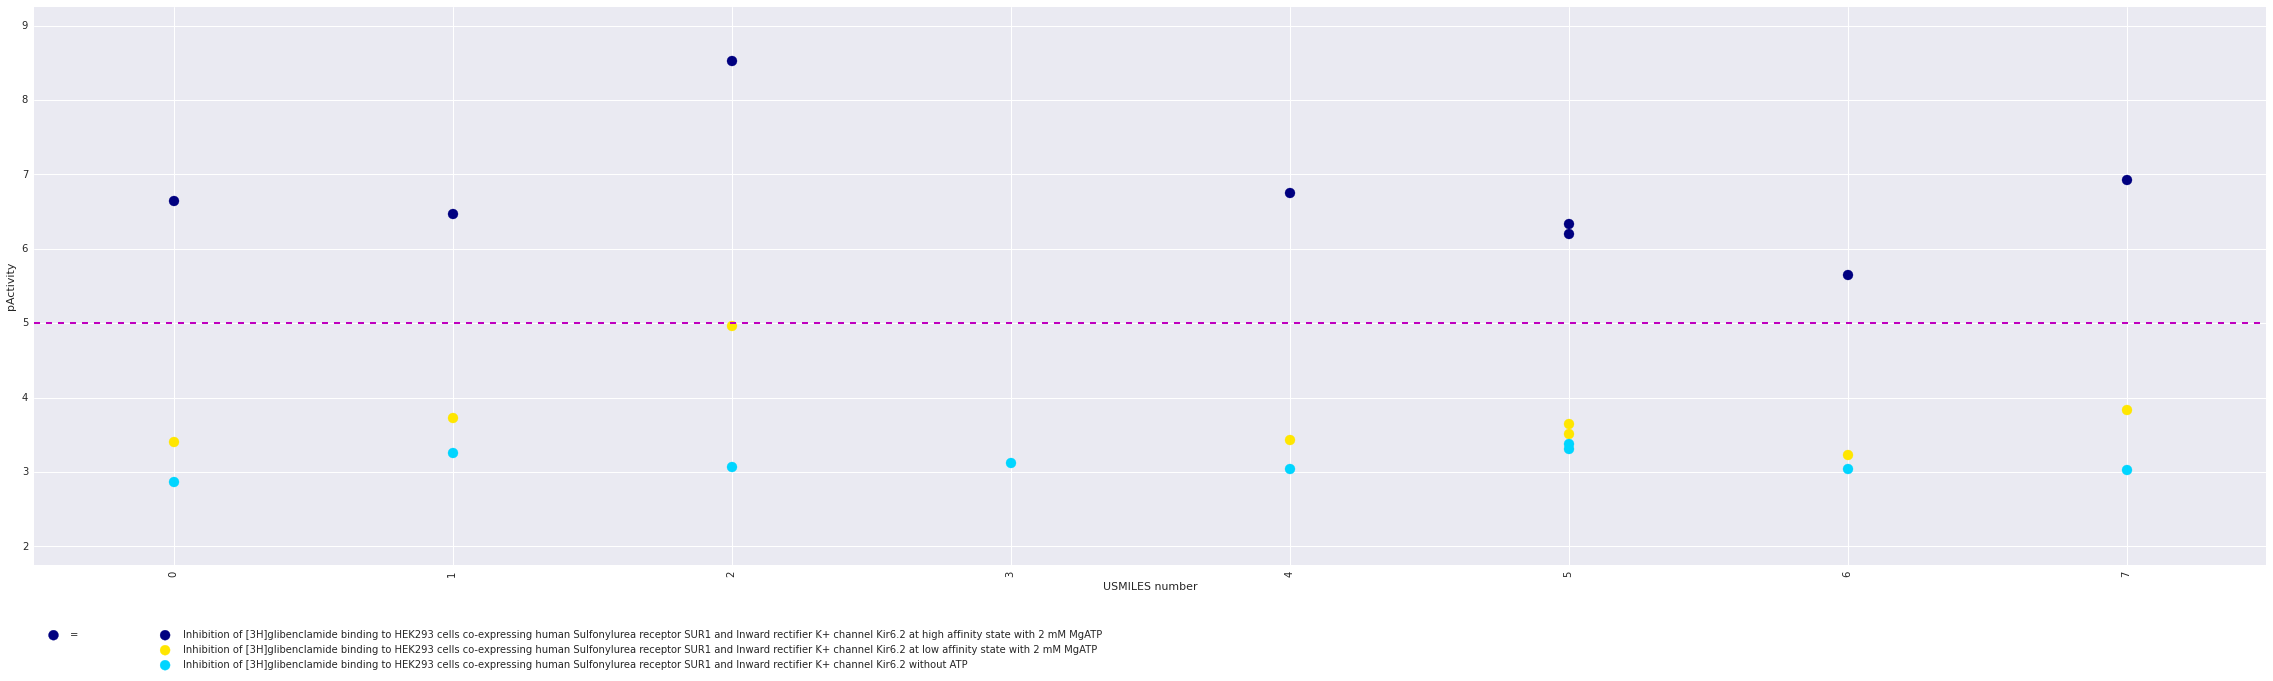

In [21]:
# Plot...

fig, ax = plt.subplots()

fig.set_size_inches(40, 10)

# X-axis...

x_positions = range(len(usmiles))

ax.set_xlim((x_positions[0]-0.5, x_positions[-1]+0.5))

ax.set_xticks(x_positions)

ax.tick_params(axis='both', direction='out')

ax.set_xticklabels(x_positions, fontsize=10, rotation=90)

ax.set_xlabel('USMILES number')

# Y-axis...

y = [-log10(x/10**9) if not np.isnan(x) else 3.0 for x in data['standard_value']]

ax.set_ylim((floor(min(y))-0.25, ceil(max(y))+0.25))

ax.set_ylabel('pActivity')
            
# Add line...
            
ax.plot((x_positions[0]-0.5, x_positions[-1]+0.5), (5, 5), color='m', linestyle='--', linewidth=2)

######

point_sets = defaultdict(list)

for i, color_class in enumerate(color_classes):
    
    ### logging.info("{}) color_class: '{}'".format(i, color_class))
        
    for j, marker_class in enumerate(marker_classes):
        
        ### logging.info("  {}) marker_class: '{}'".format(j, marker_class))
        
        subset = data.query("({} == @color_class) and ({} == @marker_class)".format(color_class_col, marker_class_col))
        
        x_subset = [usmiles.index(x) for x in subset['usmiles']]
        
        ### logging.info("    x_subset: [{}]".format(', '.join("{}".format(x) for x in x_subset)))
        
        y_subset = [-log10(x/10**9) if not np.isnan(x) else 3.0 for x in subset['standard_value']]
        
        assert(len(x_subset) == len(y_subset))
                
        ### logging.info("    y_subset: [{}]".format(', '.join("{}".format(round(x, 2)) for x in y_subset)))
        
        point_set = ax.scatter(x_subset, y_subset, s=100, color=color_map[color_classes.index(color_class)], marker=marker_list[marker_classes.index(marker_class)], label="{}, {}".format(color_class, marker_class))
        
        point_sets[i].append(point_set)
                
######

legend0 = ax.legend(point_sets[0], marker_classes, bbox_to_anchor=(0.0, -0.1), loc=2)

legend1 = ax.legend([x[0] for x in point_sets.values()], color_classes, bbox_to_anchor=(0.05, -0.1), loc=2)

_ = ax.add_artist(legend0)

_N.B._ 3 is used as a dummy-value for missing activity values.

In [22]:
# Inspect compounds...

HTML(table_of_compounds.to_html())

,usmiles,cmpds
usmiles_n,,
0,CC(C)(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1,[CHEMBL336586]
1,CC(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1,[CHEMBL131971]
2,CC1(NC2=NS(=O)(=O)c3sc(Cl)cc3N2)CCC1,[CHEMBL134168]
3,CC1=NS(=O)(=O)c2cc(Cl)ccc2N1,[CHEMBL181]
4,CCC(C)(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1,[CHEMBL135091]
5,CCC(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1,[CHEMBL2111887]
6,CCCNC1=NS(=O)(=O)c2sc(Cl)cc2N1,[CHEMBL133596]
7,O=S1(=O)NC(NC2CCC2)=Nc2cc(Cl)sc21,[CHEMBL133663]


In [23]:
# Inspect raw data...
    
cols = ['assay_chemblid', 'description', 'parent_cmpd_chemblid', 'standard_relation', 'standard_value', 'standard_units', 'pchembl_value', 'active', 'usmiles_n', 'usmiles']

HTML(data[cols].to_html())

,assay_chemblid,description,parent_cmpd_chemblid,standard_relation,standard_value,standard_units,pchembl_value,active,usmiles_n,usmiles
0,CHEMBL810541,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 at high affinity state with 2 mM MgATP,CHEMBL336586,=,230,nM,6.64,1,0,CC(C)(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1
1,CHEMBL810542,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 at low affinity state with 2 mM MgATP,CHEMBL336586,=,393000,nM,NaN,0,0,CC(C)(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1
2,CHEMBL810543,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 without ATP,CHEMBL336586,=,1350000,nM,NaN,0,0,CC(C)(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1
3,CHEMBL810541,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 at high affinity state with 2 mM MgATP,CHEMBL131971,=,340,nM,6.47,1,1,CC(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1
4,CHEMBL810542,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 at low affinity state with 2 mM MgATP,CHEMBL131971,=,187000,nM,NaN,0,1,CC(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1
5,CHEMBL810543,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 without ATP,CHEMBL131971,=,554000,nM,NaN,0,1,CC(C)NC1=NS(=O)(=O)c2sc(Cl)cc2N1
6,CHEMBL810541,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 at high affinity state with 2 mM MgATP,CHEMBL134168,=,3,nM,8.52,1,2,CC1(NC2=NS(=O)(=O)c3sc(Cl)cc3N2)CCC1
7,CHEMBL810542,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 at low affinity state with 2 mM MgATP,CHEMBL134168,=,10800,nM,4.97,0,2,CC1(NC2=NS(=O)(=O)c3sc(Cl)cc3N2)CCC1
8,CHEMBL810543,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 without ATP,CHEMBL134168,=,859000,nM,NaN,0,2,CC1(NC2=NS(=O)(=O)c3sc(Cl)cc3N2)CCC1
9,CHEMBL810543,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 without ATP,CHEMBL181,=,750000,nM,NaN,0,3,CC1=NS(=O)(=O)c2cc(Cl)ccc2N1


In [24]:
# Inspect assays...

def f(x):
    
    x['assay_chemblid'] = '<a target="_blank" href="https://www.ebi.ac.uk/chembl/assay/inspect/{}">{}</a>'.format(* [x['assay_chemblid']]*2)
    
    return x

table_of_assays.sort('description').reset_index(drop=True).apply(f, axis=1)

,description,assay_chemblid,n
0,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 at high affinity state with 2 mM MgATP,CHEMBL810541,8
1,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 at low affinity state with 2 mM MgATP,CHEMBL810542,8
2,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 without ATP,CHEMBL810543,7
3,Inhibition of [3H]glibenclamide binding to HEK293 cells co-expressing human Sulfonylurea receptor SUR1 and Inward rectifier K+ channel Kir6.2 without ATP,CHEMBL810540,2


### Conclusions

* GRIN1 / Rat: there seems to be considerable discepancies among the various assays, and merging data for the different isoforms may not be supportable in this case. This can also be seen in the notebook '[GRIN1](Correlation_Targets_Rat.html)'.